In [1]:
import string

import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix

import gensim
import unicodedata

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import (CountVectorizer, HashingVectorizer, TfidfVectorizer)
from imblearn.over_sampling import SMOTE

# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD


from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pathlib import Path


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [3]:
df = pd.read_csv("../input/news-summary/news_summary.csv", encoding = "latin-1")
df.head(1)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...


In [4]:
more_df = pd.read_csv('../input/news-summary/news_summary_more.csv')
more_df.head(1)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."


In [5]:
more_df

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [6]:
# create a preprocessing class
class Preprocessor:
    def __init__(self, df) -> None:
        self.df = df

    
    # convert all charecters to lower case
    def convertToLower(self):
        self.df["headlines"] = self.df["headlines"].apply(lambda x: x.lower())
        self.df["text"] = self.df["text"].apply(lambda x: x.lower())
        return self.df

    
    # remove stop words
    def removeStopWords(self):
        stop = stopwords.words("english")
        self.df["text"] = self.df["text"].apply(
            lambda x: " ".join([word for word in x.split() if word not in stop])
        )
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: " ".join([word for word in x.split() if word not in stop])
        )
        return self.df


    
    # remove whitespaces
    def removeWhitespaces(self):
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: " ".join(x.split())
        )
        self.df["text"] = self.df["text"].apply(
            lambda x: " ".join(x.split())
        )
        return self.df
    
    
    def removePunctuation(self):
        self.df["headlines"] = self.df["headlines"].str.replace("[<>()|&©ø\[\]\'\",;?~*!]", "")
        self.df["text"] = self.df["text"].str.replace("[<>()|&©ø\[\]\'\",;?~*!]", "")
        return self.df
        
        
    # remove urls
    def removeURLs(self):
        self.df["text"] = self.df["text"].str.replace(
            "https?://\S+|www\.\S+", ""
        )
        self.df["headlines"] = self.df["headlines"].str.replace(
            "https?://\S+|www\.\S+", ""
        )
        return self.df

    
    # snowball stemmer algorithm
    def snowballstemmer(self):
        stemmer = SnowballStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: stem_words(x)
        )
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    
    # port stemmer algorithm
    def porterstemmer(self):
        stemmer = PorterStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["text"] = self.df["text"].apply(
            lambda x: stem_words(x)
        )
        
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    
    # lemmatizing
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()

        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

        self.df["text"] = self.df["text"].apply(
            lambda x: lemmatize_words(x)
        )
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: lemmatize_words(x)
        )
        return self.df

    
    # word tokenization using nltk
    def wordTokenization(self):
        self.df["text"] = self.df["text"].apply(
            lambda x: nltk.word_tokenize(x)
        )
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: nltk.word_tokenize(x)
        )
        return self.df
    
    def removeMissingValues(self):
        self.df = self.df.dropna()
        return self.df
        

    def preprocess(self):
        self.df = self.convertToLower()
        self.df = self.removeStopWords()
        self.df = self.removePunctuation()
        self.df = self.removeURLs()
        self.df = self.removeWhitespaces()
        #self.df = self.snowballstemmer()
        self.df = self.porterstemmer()
        # self.df = self.lemmatize()
        #self.df = self.wordTokenization()
        self.df = self.removeMissingValues()
        return self.df

In [7]:
preproccesor = Preprocessor(more_df)
preprocessed_df = preproccesor.preprocess()
preprocessed_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.


,headlines,text
0,upgrad learner switch career ml al 90% salari ...,saurav kant alumnu upgrad iiit-b pg program ma...
1,delhi techi win free food swiggi one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma-l india 12-match ...,new zealand defeat india 8 wicket fourth odi h...
3,aegon life iterm insur plan help custom save tax,aegon life iterm insur plan custom enjoy tax b...
4,known hirani yr metoo claim true: sonam,speak sexual harass alleg rajkumar hirani sona...


In [8]:
df = df[["text","ctext"]]
df.columns = ["headlines","text"]
df = df.dropna()
preprocessor_df = Preprocessor(df)
preprocessed_normal_df = preprocessor_df.preprocess()
preprocessed_normal_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.


,headlines,text
0,administr union territori daman diu revok orde...,daman diu administr wednesday withdrew circula...
1,malaika arora slam instagram user troll divorc...,special number tvappear bollywood actor malaik...
2,indira gandhi institut medic scienc igim patna...,indira gandhi institut medic scienc igim patna...
3,lashkar-e-taiba kashmir command abu dujana kil...,lashkar-e-taiba kashmir command abu dujana kil...
4,hotel maharashtra train staff spot sign sex tr...,hotel mumbai indian citi train staff spot sign...


In [9]:
preprocessed_normal_df.describe()

,headlines,text
count,4396,4396
unique,4396,4341
top,administr union territori daman diu revok orde...,aaj tak live tv live elect result congratul sh...
freq,1,13


In [10]:
class EDADescriber:
    def __init__(self,df):
        self.df = df
        self.punc = string.punctuation
        self.stopwords = nltk.corpus.stopwords.words('english')
        
    def count_stopwords(self,text):
        word_tokens = nltk.word_tokenize(text) #splitta i pezzi
        stopwords_x = [w for w in word_tokens if w in self.stopwords]
        return len(stopwords_x)
    
    def createSummaryDataframe(self):
        dataset = pd.DataFrame()
        dataset['headlines_sent_count'] = self.df['headlines'].apply(lambda x : len(nltk.sent_tokenize(x)))
        dataset['text_sent_count'] = self.df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
        dataset['headlines_word_count'] = self.df['headlines'].apply(lambda x : len(x.split()))
        dataset['text_word_count'] = self.df['text'].apply(lambda x : len(x.split()))
        dataset['headlines_char_count'] = self.df['headlines'].apply(lambda x : len(x.replace(" ","")))
        dataset['text_char_count'] = self.df['text'].apply(lambda x : len(x.replace(" ","")))
        dataset['headlines_word_density'] = dataset['headlines_word_count'] / (dataset['headlines_char_count'] + 1)
        dataset['text_word_density'] = dataset['text_word_count'] / (dataset['text_char_count'] + 1)
        dataset['headlines_sent_density'] = dataset['headlines_sent_count'] / (dataset['headlines_word_count'] + 1)
        dataset['text_sent_density'] = dataset['text_sent_count'] / (dataset['text_word_count'] + 1)
        dataset['headlines_punc_count'] = self.df['headlines'].apply(lambda x : len([a for a in x if a in self.punc]))
        dataset['text_punc_count'] = self.df['text'].apply(lambda x : len([a for a in x if a in self.punc]))
        dataset['text_stopw_count'] =  self.df['text'].apply(lambda x : self.count_stopwords(x))
        dataset['headlines_stopw_count'] =  self.df['headlines'].apply(lambda x : self.count_stopwords(x))
        dataset['headlines_stopw_density'] = dataset['headlines_stopw_count'] / (dataset['headlines_word_count'] + 1)
        dataset['text_stopw_density'] = dataset['text_stopw_count'] / (dataset['text_word_count'] + 1)
        return dataset
    
    
    def plot_histograms(self, plot_vars, xlim, figsize):
        import random
        data = self.createSummaryDataframe()
        fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
        for i in range(plot_vars.shape[1]):
            sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                         ax=axes[i], bins= 50, norm_hist = True)
            axes[i].set_xlim(left=0, right=xlim[i])
        fig.tight_layout()

In [11]:
edaDesc = EDADescriber(df)
edadesc_summary = edaDesc.createSummaryDataframe()
edadesc_summary[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,4396.000000,4396.000000,4396.000000,4396.000000,4396.000000
mean,10.599864,205.012966,1152.846906,3.982484,25.771838
std,16.082263,216.108595,1211.059099,7.560806,45.341892
min,1.000000,1.000000,3.000000,0.000000,0.000000
25%,5.000000,112.000000,628.750000,1.000000,12.000000
50%,8.000000,170.000000,949.000000,2.000000,18.000000
75%,13.000000,245.000000,1367.000000,5.000000,28.000000
max,572.000000,7249.000000,41544.000000,185.000000,1188.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

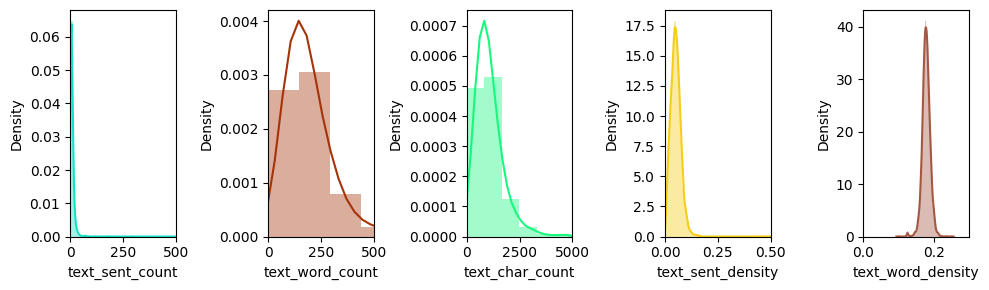

In [12]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the histograms 
edaDesc.plot_histograms(plot_vars, [500, 500, 5000, 0.5, 0.3], figsize=(10,3))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

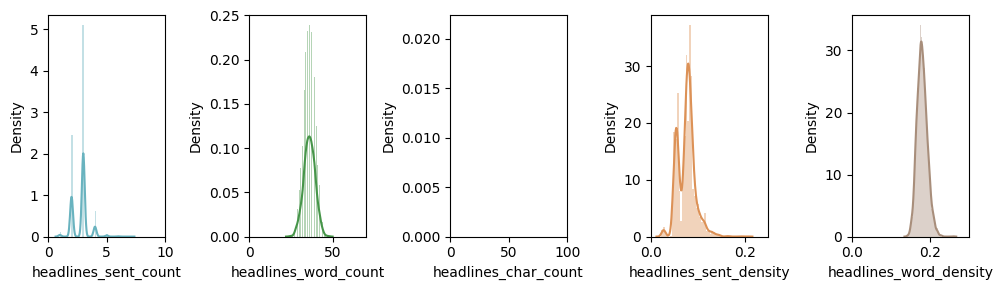

In [13]:
plot_vars=np.array([['headlines_sent_count', 'headlines_word_count', 'headlines_char_count','headlines_sent_density','headlines_word_density']])
edaDesc.plot_histograms(plot_vars, [10, 70, 100, 0.25, 0.3], figsize=(10,3))

In [14]:
train_df, test_df = model_selection.train_test_split(df, test_size =0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

### Word clouds & Most Frequent Terms

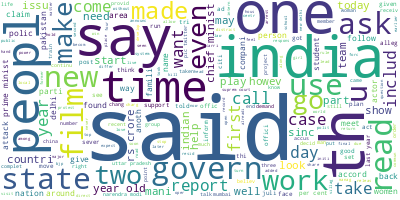

In [15]:
from wordcloud import WordCloud
long_string = ','.join(list(preprocessed_normal_df["text"]))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

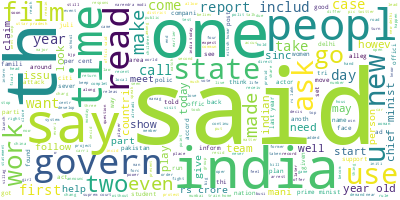

In [16]:
headline_string = ','.join(list(preprocessed_normal_df["headlines"]))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Tokenizing using T5-transformer tokenizer

In [17]:
class SummarizerTokenizer(Dataset):
    def __init__(self, data, tokenizer, text_max_token_len, summary_max_token_len):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        

    def getSummary(self, index: int):
        data_row = self.data.iloc[index]
        text = data_row['text']

        text_encoding = self.tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = self.tokenizer(
            data_row['headlines'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'],
            text_attention_mask=text_encoding['attention_mask'],
            labels=labels,
            labels_attention_mask=summary_encoding['attention_mask']
        )

In [18]:
class SummarizerDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size, text_max_token_len, summary_max_token_len):
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def setup(self, stage = None):
        self.train_dataset = SummarizerTokenizer(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = SummarizerTokenizer(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle=True,
            num_workers=2
        )
    def validation_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [19]:
MODEL = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [20]:
train_df

,headlines,text
3911,trai chairman rs sharma said telecom regul adv...,new delhi apr 7 pti trai chairman r sharma tod...
1491,punjab haryana high court thursday observ go s...,punjab haryana high court divis bench hear mur...
4002,govern seek data deposit made individu demonet...,taxman seek data deposit made assesse demoneti...
2572,telecom depart made mandatori phone includ fea...,cite consum safeti especi women telecom depart...
1828,madra high court judg thursday express doubt d...,madra high court today express doubt decemb 5 ...
...,...,...
1933,delhi metro friday announc make 10 station cas...,delhi metro make 10 station across variou sect...
3421,water tanker scam happen 2012 sheila dikshit t...,sack delhi minist kapil mishra claim saw forme...
1455,court paper case 13 aap mla show delhi polic s...,delhi policearrest 13 mlasof rule aam aadmi pa...
3035,everi home patwa toli villag bihar gaya distri...,though bihar got defam topper scam xii board e...


Token indices sequence length is longer than the specified maximum sequence length for this model (3056 > 512). Running this sequence through the model will result in indexing errors


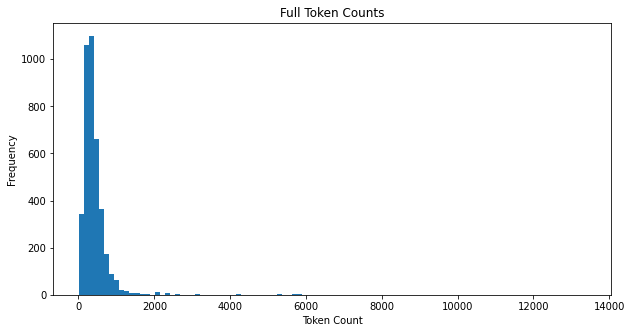

In [21]:
full_token_counts , summary_token_counts = [], []
for i in range(len(train_df)):
    data_row = train_df.iloc[i]
    full_token_count = len(tokenizer.encode(data_row['text']))
    summary_token_count = len(tokenizer.encode(data_row['headlines']))
    full_token_counts.append(full_token_count)
    summary_token_counts.append(summary_token_count)


# plot the distribution of the token counts
plt.figure(figsize=(10,5))
plt.hist(full_token_counts, bins=100)
plt.title('Full Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

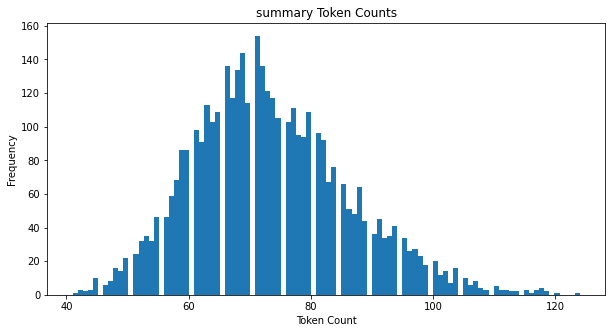

In [22]:
plt.figure(figsize=(10,5))
plt.hist(summary_token_counts, bins=100)
plt.title('summary Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [23]:
NUM_EPOCHS = 3
BATCH_SIZE = 32

data_module = SummarizerDataModule(train_df, test_df, tokenizer, BATCH_SIZE, 512, 128)

In [24]:
class SummarizerModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL,return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss , outputs = self(input_ids = input_ids, attention_mask = attention_mask, decoder_attention_mask = labels_attention_mask, labels = labels)

        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss , outputs = self(input_ids = input_ids, attention_mask = attention_mask, decoder_attention_mask = labels_attention_mask, labels = labels)

        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def optimizer(self):
        return AdamW(self.parameters(), lr=1e-4)

    

In [25]:
model = SummarizerModel()


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [26]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.loggers import TensorBoardLogger

# checkpoint_callback = ModelCheckpoint(
#     dirpath='checkpoints',
#     filename='best-checkpoint',
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# logger = TensorBoardLogger("lightning_logs", name='news-summary')

# trainer = pl.Trainer(
#     logger=logger,
#     checkpoint_callback=checkpoint_callback,
#     max_epochs = NUM_EPOCHS,
#     gpus=1,
#     progress_bar_refresh_rate=30
# )